In [196]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy
from sklearn import preprocessing

In [197]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/wustl_attacks.csv", sep=",")

In [198]:
attacks = preprocessing.normalize(attacks.to_numpy()[:, 1:], norm="max", axis=0)

# swap sport to front
# attacks[:, [0, 1]] = attacks[:, [1, 0]]
# # swap dport to after sport
# attacks[:, [1, 2]] = attacks[:, [2, 1]]
# # swap protocols to after dport
# attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

# should probably add batch and shuffle

batch_size = 64
num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
# train_dataset = attacks[:int(np.floor(attacks.shape[0]*4/5))]
train_dataset = attacks[:10000]
# train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:19968]).shuffle(10000).batch(batch_size))
test_dataset = attacks[int(np.floor(attacks.shape[0]*4/5)):]
# test_dataset = attacks[30000:32000]


seq_length = 10
latent_dim = 100

In [199]:
test_dataset.shape

(17404, 27)

In [200]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [201]:
# encoder

inputs = tf.keras.layers.Input(shape=[num_features,1])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(z)
z = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(z)
codings_mean = tf.keras.layers.Dense(latent_dim)(z) # mu
codings_log_var = tf.keras.layers.Dense(latent_dim)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder

decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
x = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(num_features*1, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([num_features, 1])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# VAE model

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# VAE losses

latent_loss = -0.5 * tf.keras.backend.sum(1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss / float(num_features)))
# variational_ae.add_loss(tf.keras.backend.mean(latent_loss))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
variational_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [202]:
noise_dim = 100

def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = [seq_length, noise_dim], recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(latent_dim, activation="tanh"))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=[latent_dim, 1], recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_data):
    return cross_entropy(tf.ones_like(fake_data), fake_data)

In [203]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [204]:
# def wasserstein_loss(y_pred, y_real):
#     return tf.keras.backend.mean(y_pred * y_real)

# def generator_wasserstein_loss(y_pred):
#     return -tf.keras.backend.mean(y_pred)

# class ClipConstraint(tf.keras.constraints.Constraint):
#     def __init__(self, clip_value):
#         self.clip_value = clip_value

In [205]:
# def make_critic(input_shape):
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     const = ClipConstraint(0.01)
#     model = tf.keras.models.Sequential()
#     # model.add(tf.keras.layers.Flatten(input_shape=(input_shape[0]*input_shape[1])))
#     # model.add(tf.keras.layers.LSTM(100, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm1"))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm2"))
#     model.add(tf.keras.layers.Dense(250, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const))

#     model.add(tf.keras.layers.Dense(200, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, name="c_lstm3"))
#     model.add(tf.keras.layers.Dense(150, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(100, kernel_initializer=init, kernel_constraint=const))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(1, name="c_dense"))
#     # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     # model.compile(loss=wasserstein_loss, optimizer=opt)
#     return model

# def make_generator(output_shape, noise_dim):
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     model = tf.keras.models.Sequential()
#     # model.add(tf.keras.layers.LSTM(100, input_shape=(5, output_shape), kernel_initializer=init, recurrent_dropout=0.4, return_sequences=True))
#     model.add(tf.keras.layers.Dense(100, input_shape=[noise_dim], kernel_initializer=init))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, recurrent_dropout=0.4))
#     model.add(tf.keras.layers.Dense(150, kernel_initializer=init))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))

#     model.add(tf.keras.layers.Dense(200, kernel_initializer=init))
#     model.add(tf.keras.layers.Dropout(0.2))
#     tf.keras.layers.BatchNormalization()
#     model.add(tf.keras.layers.LeakyReLU(0.2))
#     # model.add(tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="tanh", kernel_initializer=init))
#     # model.add(tf.keras.layers.Reshape([output_shape[0], output_shape[1]]))
#     model.add(tf.keras.layers.Dense(output_shape, activation="tanh"))
#     # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     # model.compile(loss=generator_wasserstein_loss, optimizer=opt)
#     return model

# def make_gan(generator, critic):
#     model = tf.keras.models.Sequential()
#     model.add(generator)
#     model.add(critic)
#     opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
#     model.compile(loss=wasserstein_loss, optimizer=opt)
#     return model

## Step 1: Train autoencoder on real data

In [206]:
# variational_ae.fit(train_dataset, train_dataset, epochs=5, batch_size=64)
history = variational_ae.fit(train_dataset, train_dataset, epochs=50, batch_size=64)

Epoch 1/50
157/157 [==============================] - 1s 1ms/step - loss: 1.1681
Epoch 2/50
157/157 [==============================] - 0s 965us/step - loss: 0.9623
Epoch 3/50
157/157 [==============================] - 0s 965us/step - loss: 0.8169
Epoch 4/50
157/157 [==============================] - 0s 987us/step - loss: 0.7127
Epoch 5/50
157/157 [==============================] - 0s 982us/step - loss: 0.6339
Epoch 6/50
157/157 [==============================] - 0s 956us/step - loss: 0.5787
Epoch 7/50
157/157 [==============================] - 0s 966us/step - loss: 0.5354
Epoch 8/50
157/157 [==============================] - 0s 971us/step - loss: 0.5031
Epoch 9/50
157/157 [==============================] - 0s 965us/step - loss: 0.4786
Epoch 10/50
157/157 [==============================] - 0s 948us/step - loss: 0.4604
Epoch 11/50
157/157 [==============================] - 0s 987us/step - loss: 0.4444
Epoch 12/50
157/157 [==============================] - 0s 938us/step - loss: 0.4323
Epo

In [207]:
vae_loss_history["wustl"] = history.history["loss"]

Text(0.5, 0, 'Epoch')

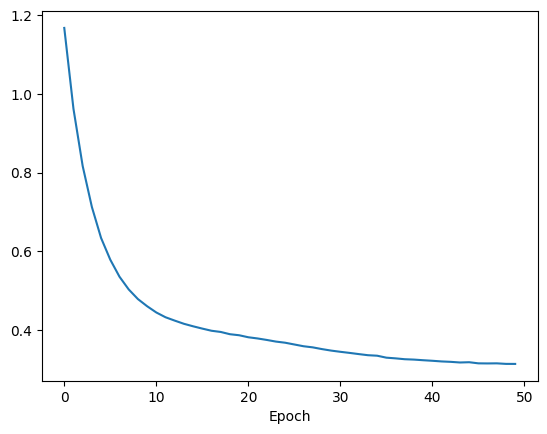

In [208]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.savefig("vae_gan_vae_loss_swat_sensor.png", dpi=800)

In [168]:
# vae_loss_history = {"swat_sensor": None, "swat_network": None, "wustl": None, "wadi": None}

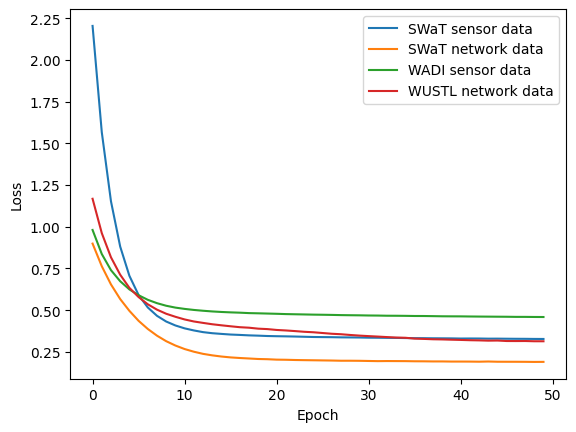

In [213]:
plt.figure()
plt.plot(vae_loss_history["swat_sensor"], label="SWaT sensor data")
plt.plot(vae_loss_history["swat_network"], label="SWaT network data")
plt.plot(vae_loss_history["wadi"], label="WADI sensor data")
plt.plot(vae_loss_history["wustl"], label="WUSTL network data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.show()
plt.savefig("vae_gan_vae_losses.png")

## Step 2: Train GAN to learn realistic latent vectors

In [12]:
# generator_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
# critic_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

# def train_step(generator, critic, dataset, latent_dim, noise_dim, n_batch=40, n_critic=5):

#     for _ in range(n_critic):

#         """
#         Train critic more often than the generator for WGAN
#         """

#         with tf.GradientTape() as critic_tape:
#             ix = np.random.randint(0, dataset.shape[0], n_batch)
#             # X_real = dataset.numpy()[ix]
#             X_real = dataset[ix]
#             noise = tf.random.normal((n_batch, noise_dim))
#             X_fake = generator(noise, training=True)

#             pred_real = critic(X_real, training=True)
#             pred_fake = critic(X_fake, training=True)

#             c_loss = wasserstein_loss(pred_real, pred_fake)
        

#         critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
#         critic_optimiser.apply_gradients(zip(critic_gradients, critic.trainable_variables))
#     # print(f"Critic loss: {c_loss}")  
    
#     """ 
#     Train generator
#     """

#     with tf.GradientTape() as gen_tape:
#         X_fake = generator(noise, training=True)
#         pred_fake = critic(X_fake, training=True)
#         g_loss = generator_wasserstein_loss(pred_fake)
#         # print(f"Generator loss: {g_loss}")
    
#     generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
#     generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))


#     return c_loss, g_loss

# def train(dataset, n_epochs=2, noise_dim=50, latent_dim=50):

#     generator = make_generator(latent_dim, noise_dim)
#     critic = make_critic((latent_dim, 1))

#     c_losses, g_losses = [], []

#     for i in range(n_epochs):
#         # print(f"Epoch: {i+1}")
#         for batch in dataset:
#             c_loss, g_loss = train_step(generator, critic, batch, latent_dim, noise_dim)
#             c_losses.append(c_loss)
#             g_losses.append(g_loss)
    
#     noise = tf.random.normal((1000, noise_dim))
#     prediction = generator.predict(noise)

#     return c_losses, g_losses, prediction

In [13]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    # noise = tf.random.normal((batch_size, seq_length, num_features))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        noise = tf.random.normal((batch_size, seq_length, noise_dim))
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [14]:
lv = variational_encoder(attacks[:10000])[0]

In [15]:
lv

<tf.Tensor: shape=(9977, 100), dtype=float32, numpy=
array([[-0.00861892, -0.02575675, -0.00199601, ...,  0.06305134,
        -0.01676309, -0.03395922],
       [-0.00861892, -0.02575675, -0.00199601, ...,  0.06305134,
        -0.01676309, -0.03395922],
       [-0.00861892, -0.02575675, -0.00199601, ...,  0.06305134,
        -0.01676309, -0.03395922],
       ...,
       [-0.01393519,  0.05409027,  0.01041131, ...,  0.00845135,
         0.02052398, -0.00888359],
       [-0.01393522,  0.05409024,  0.01041128, ...,  0.00845139,
         0.02052398, -0.00888351],
       [-0.01393522,  0.05409024,  0.01041128, ...,  0.00845139,
         0.02052398, -0.00888351]], dtype=float32)>

In [16]:
# real_latent_vectors = np.split((variational_encoder(attacks[:20000])[0]).numpy(), 200)
noise = tf.random.normal((batch_size, seq_length, num_features))
latent_vector_dataset = (tf.data.Dataset.from_tensor_slices((variational_encoder(attacks[:10000])[0]).numpy()).shuffle(50000).batch(64))
latent_vector_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)>

In [17]:
def train(dataset, epochs):

    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
        dlosses.append(dloss)
        glosses.append(gloss)


    return dlosses, glosses

In [18]:
# c_losses, g_losses, pred = train(real_latent_vectors, 10, 30, latent_dim)
dlosses, glosses = train(latent_vector_dataset, epochs=30)

In [19]:

# noise_dim = 30
# n_batch = 64
# # create the critic
# critic = make_critic([latent_dim, 1])
# # create the generator
# # generator = make_generator((n_batch, latent_dim))
# generator = make_generator(latent_dim, noise_dim)
# # create the gan
# gan = make_gan(generator, critic)
# # load image data


# real_latent_vectors = variational_encoder(test_dataset)[0]
# epochs = 10
# # train model
# c1_loss, c2_loss, g_loss = train(generator, critic, gan, dataset=test_dataset[:10000], latent_dim=latent_dim, noise_dim=noise_dim, n_epochs=epochs, n_batch=n_batch)

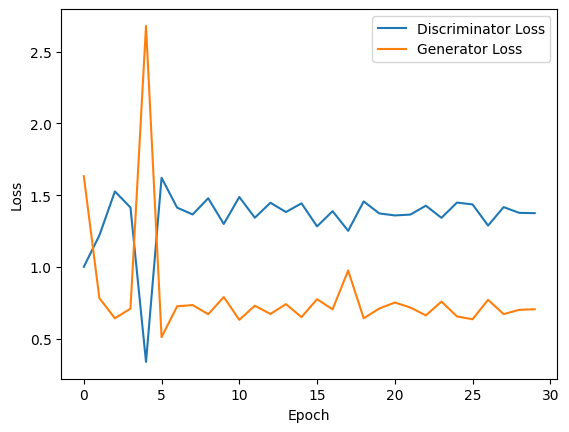

<Figure size 640x480 with 0 Axes>

In [29]:
# plt.plot(c_losses, label="critic loss real data")
# plt.plot(g_losses, label="generator")
plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("vae_gan_wadi_sensor.png", dpi=800)

## Step 3: Use generator to make latent vectors and decode with decoder

In [21]:
test_noise = tf.random.normal((test_dataset.shape[0], seq_length, latent_dim))
preds = generator.predict(test_noise)
latent_vectors = preds.reshape(test_dataset.shape[0], latent_dim)
data = variational_decoder(latent_vectors)

# data.numpy().shape, test_dataset.shape

63/63 [==============================] - 1s 3ms/step


In [22]:
data.shape

TensorShape([1996, 69, 1])

In [23]:
scipy.stats.ks_2samp(test_dataset.reshape(test_dataset.shape[0] * num_features,), data.numpy().reshape(test_dataset.shape[0] * num_features,))

KstestResult(statistic=0.46683947605355647, pvalue=0.0, statistic_location=0.5714272260665894, statistic_sign=-1)

In [24]:
scipy.stats.wasserstein_distance(test_dataset.reshape(test_dataset.shape[0] * num_features,), data.numpy().reshape(test_dataset.shape[0] * num_features,))

0.323210280902608

In [28]:
# df = pd.DataFrame(data.numpy().reshape((test_dataset.shape[0] * num_features)))
# df.to_csv("vae_gan_wadi_sensor.csv", index=False)

In [26]:
# from sklearn.neighbors import KernelDensity
# kde_gen = KernelDensity(kernel='epanechnikov').fit(data.numpy()[:, 10].reshape(-1, 1))
# kde_dat = KernelDensity(kernel='epanechnikov').fit(test_dataset[:1000, 10].reshape(-1, 1))

# plt.plot(kde_gen.score_samples(data.numpy()[:, 10].reshape(-1, 1)))

In [27]:
# plt.plot(kde_dat.score_samples(test_dataset[:1000, 10].reshape(-1, 1)))